### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [ ]:
#Todo
#Remove punctuation
#Use embedding that represents headslines
#Tokenizer with special token

In [2]:
# You will need to download any word embeddings required for your code, e.g.:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

--2021-02-19 10:15:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-19 10:15:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-19 10:15:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [7]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
! pip install transformers

In [24]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import spacy
from spacy.tokenizer import Tokenizer
import re
import pdb
import random
import csv
import tqdm
import multiprocessing
import pickle


In [42]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [43]:
# Load data
train_df = pd.read_csv('drive/MyDrive/Imperial_College/NLP_CW/ic_nlp_cw/task-1/train.csv')
train_df


,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0
...,...,...,...,...,...
9647,10899,State officials blast ' unprecedented ' DHS <m...,idea,0,0.0
9648,1781,Protesters Rally for <Refugees/> Detained at J...,stewardesses,20000,0.4
9649,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6
9650,14483,Columbia police hunt woman seen with <gun/> ne...,cake,32200,1.4


In [5]:
test_df

NameError: ignored

In [44]:
extra_data = pd.read_csv('drive/MyDrive/Imperial_College/NLP_CW/ic_nlp_cw/task-1/extra_train_data.csv')
#train_df = train_df + extra_data
test_df = pd.read_csv('drive/MyDrive/Imperial_College/NLP_CW/ic_nlp_cw/task-1/dev.csv')
#train_df
new_train_df = pd.concat((train_df, extra_data))
#print(new_train_df.loc[new_train_df['id'] == 70])
new_train_df

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0
...,...,...,...,...,...
8243,108243,Banning Facial <Recognition/> Is n’t Enough - ...,Cleansers,22222,2.0
8244,108244,Trump is reportedly threatening <Republicans/>...,children,21100,0.8
8245,108245,Peruvian indigenous group wins suit to block o...,Women,22110,1.2
8246,108246,Joe Rogan says he 's probably voting for <Bern...,Illuminati,22000,0.8


### Training for BILSTM

In [79]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, bert=False):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    train_losses = np.zeros(number_epoch)
    valid_losses = np.zeros(number_epoch)
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:
            optimizer.zero_grad()

            feature, target = batch
            feature_1= feature[0].to(device)
            feature_2 = feature[1].to(device)
            target = target.to(device)
            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden_1 = model.init_hidden()
            model.hidden_2 = model.init_hidden()

            feature = (feature_1, feature_2)
            predictions = model(feature).squeeze(1)

            #print(predictions.shape)
            #print(target.shape)

            loss = loss_fn(predictions, target)
                        
            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy()) 
            
            loss.backward(retain_graph=True)
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        train_losses[epoch-1] = epoch_loss
        valid_losses[epoch-1] = valid_loss
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
    return train_losses, valid_losses

In [80]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0



    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch
            feature_1= feature[0].to(device)
            feature_2 = feature[1].to(device)
            target = target.to(device)

            feature = (feature_1, feature_2)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden_1 = model.init_hidden()
            model.hidden_2 = model.init_hidden()

            predictions = model(feature).squeeze(1)
            #predictions.requires_grad = True
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [ ]:
'''
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

SyntaxError: ignored

In [ ]:
# To create our vocab

def custom_tokenizer(nlp):
    
    replacement_re = re.compile(r'^<*/>') #do not split replacement format
    prefix_re = re.compile(r'''^[\[\("]''')
    suffix_re = re.compile(r''',[\]\)"']$''')
    infix_re = re.compile(r'''[-\,.~]''')
    
    
    return Tokenizer(nlp.vocab,
                     token_match = replacement_re.match,
                     prefix_search=prefix_re.search,
                     suffix_search=suffix_re.search,
                     infix_finditer = infix_re.finditer  
                    )



def preprocessor(data,edits):
    """
    Creating a corpus of all the tokens used
    """
    punctuation = "\":\.,"
    nlp = spacy.load("en_core_web_sm")
    nlp.tokenizer = custom_tokenizer(nlp)
    
    tokenized_corpus_1= [] # Let us put the tokenized corpus in a list
    tokenized_corpus_2= []
    
    
    for i, sentence in enumerate(data):

        sentence = sentence.lower()
        tokenized_sentence_1 = []
        tokenized_sentence_2 = []

        for token in nlp(sentence): # simplest split is

            if token.text in punctuation:
                continue
            else:
                
                if token.text[0] == '<':
                    tokenized_sentence_1.append("???")
                    tokenized_sentence_2.append("???")
                    
                    tokenized_sentence_2.append(edits[i])

                    
                    tokenized_sentence_1.append(token.text[1:-2])
                else:
                    tokenized_sentence_2.append(token.text)
                
                    tokenized_sentence_1.append(token.text)


        tokenized_corpus_1.append(tokenized_sentence_1)
        tokenized_corpus_2.append(tokenized_sentence_2)
        #print(tokenized_corpus_1[:5])
        #print(tokenized_corpus_2[:5])

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus_1:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)
    
    for token in edits:
        
        if token not in vocabulary:
            
            vocabulary.append(token)

    return vocabulary, tokenized_corpus_1, tokenized_corpus_2

In [ ]:
'''
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocessor_bert(data,edits):
    """
    Creating a corpus of all the tokens used
    """
    next = False
    punctuation = "\":\.,"
    #nlp = spacy.load("en_core_web_sm")
    
    #nlp.tokenizer = custom_tokenizer(nlp)
    
    tokenized_corpus_1= [] # Let us put the tokenized corpus in a list
    tokenized_corpus_2= []
    tokenized_mask_corpus = []
    
    
    for i, sentence in enumerate(data):

        sentence = sentence.lower()
        tokenized_sentence_1 = []
        tokenized_sentence_2 = []
        tokenized_mask_sentence = []

        for token in tokenizer_bert.tokenize(sentence): # simplest split is

            if token in punctuation:
                continue
            else:
                
                if token == '<':
                    print(token)
                    next = True

                    
                    #tokenized_sentence_2.append(edits[i])

                    
                    #tokenized_sentence_1.append(token[1:-2])
                elif token == '>' or token == '/':
                    continue
                else:
                    tokenized_sentence_1.append(token)
                    
                    if next:
                        tokenized_sentence_2.append(edits[i])
                        tokenized_mask_sentence.append(1)
                        next = False
                    else:
                        tokenized_sentence_2.append(token)
                        tokenized_mask_sentence.append(0)
                
        tokenized_corpus_1.append(tokenized_sentence_1)
        tokenized_corpus_2.append(tokenized_sentence_2)
        tokenized_mask_corpus.append(tokenized_mask_sentence)
        print(tokenized_corpus_1[:5])
        print(tokenized_corpus_2[:5])
        print(tokenized_mask_corpus[:5])
        if i==3:
          raise
    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus_1:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)
    
    for token in edits:
        
        if token not in vocabulary:
            
            vocabulary.append(token)

    return vocabulary, tokenized_corpus_1, tokenized_corpus_2
preprocessor_bert(training_data,train_df['edit'])

In [ ]:
'''def collate_fn_padd(batch):
    #We add padding to our minibatches and create tensors for our model


    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels
'''
def collate_fn_padd(batch):
    
    #We add padding to our minibatches and create tensors for our model
    

    batch_labels = [l for f, g, l in batch]
    batch_features = [(f,g) for f, g, l in batch]
    

    batch_features_len = [len(f) for f, g, l in batch]


    seq_tensor_1 = torch.zeros((len(batch), 50)).long()
    seq_tensor_2 = torch.zeros((len(batch), 50)).long()

    
    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor_1[idx, :seqlen] = torch.LongTensor(seq[0])
        seq_tensor_2[idx, :seqlen] = torch.LongTensor(seq[1])
    batch_labels = torch.FloatTensor(batch_labels)
    

    return (seq_tensor_1, seq_tensor_2), batch_labels

'''
def collate_fn_pad(batch):

    original, edit, labels = zip(*batch)
    padded_original = torch.nn.utils.rnn.pad_sequence(original, batch_first=True,padding_value=0)
    padded_edit = torch.nn.utils.rnn.pad_sequence(edit, batch_first=True,padding_value=0)
    labels = torch.Tensor(labels)
    return (padded_org, padded_edit, labels)
'''


class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]
    
class Task1Dataset_double(Dataset):

    def __init__(self, train_data_1,train_data_2, labels):
        self.x_train_1 = train_data_1
        self.x_train_2 = train_data_2
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train_1[item],self.x_train_2[item], self.y_train[item]    


In [ ]:
class BiLSTM_double(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM_double, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm_1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.lstm_2 = nn.LSTM(embedding_dim,hidden_dim, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.fc = nn.Linear(2*50*100, hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, hidden_dim//4)

        self.hidden_1 = self.init_hidden()
        self.hidden_2 = self.init_hidden()
        self.hidden2label = nn.Linear(hidden_dim//4, 1)


        self.d1 = nn.Dropout(0.3)
        self.d2 = nn.Dropout(0.3)
        self.d3 = nn.Dropout(0.3)
        self.d4 = nn.Dropout(0.3)
        self.d5 = nn.Dropout(0.3)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        
        return torch.zeros(2, self.batch_size, self.hidden_dim, requires_grad = True).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim, requires_grad = True).to(self.device)

    def forward(self, sentence):
        self.embedded_1 = self.embedding(sentence[0])
        self.embedded_1 = self.embedded_1.permute(1, 0, 2) #Needed for LSTMs

        self.embedded_2 = self.embedding(sentence[1])
        self.embedded_2 = self.embedded_2.permute(1, 0, 2) #Needed for LSTMs

        #lstm_out : (seq_len,batch_size,num_directions (2) * hidden_size (50))
        #hidden : (num_layers * num_directions, batch_size,hidden_size)
        lstm_out_1, self.hidden_1 = self.lstm_1(
            self.embedded_1.view(len(self.embedded_1), self.batch_size, self.embedding_dim), self.hidden_1)
        
        lstm_out_1 = F.leaky_relu(self.d1(lstm_out_1))

        lstm_out_2, self.hidden_2 = self.lstm_2(
            self.embedded_2.view(len(self.embedded_2), self.batch_size, self.embedding_dim), self.hidden_2)
        
        lstm_out_2 = F.leaky_relu(self.d2(lstm_out_2))
        
        #out : (1)
        lstm_out_1 = lstm_out_1.permute(1,0,2)
        lstm_out_2 = lstm_out_2.permute(1,0,2)

        out1 = self.fc(torch.cat((lstm_out_1.reshape(self.batch_size, -1),lstm_out_2.reshape(self.batch_size, -1)), dim = 1))
        out1 = F.leaky_relu(self.d3(out1))

        out2 = self.fc2(out1)
        out2 = F.leaky_relu(self.d4(out2))

        out3 = self.fc3(out2)
        out3 = F.leaky_relu(self.d5(out3))

        out = self.hidden2label(out3)
        return out

In [ ]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['original']
test_data = test_df['original']

# Creating word vectors
#training_vocab, training_tokenized_corpus = create_vocab(training_data)
#test_vocab, test_tokenized_corpus = create_vocab(test_data)
training_vocab, training_tokenized_corpus_1,training_tokenized_corpus_2=  preprocessor(training_data,train_df['edit'])
test_vocab, test_tokenized_corpus_1,test_tokenized_corpus_2=  preprocessor(test_data,test_df['edit'])

#print("Vocabulary individual creation - done")

# Creating joint vocab from test and train:
#joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))
joint_vocab, joint_tokenized_corpus_1,joint_tokenized_corpus_2 = preprocessor(pd.concat([training_data, test_data]),pd.concat([train_df['edit'],test_df['edit']],ignore_index = True))

print("Vocabulary joined creation - done")



print("Vocab created.")

In [ ]:
# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

#Add special character -> embedding vector of ones 
wvecs.append(np.ones(100))

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1 #zero padding
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)





In [ ]:
word2idx['<unk>'] = 1
idx2word[1] = '<unk>'
mean = np.mean(wvecs, axis=0) # initialize unknown token as mean
#wvecs = np.vstack((wvecs, mean))
wvecs[0] = mean


In [ ]:


vectorized_seqs_1 = [[word2idx[tok] if tok in word2idx else word2idx['<unk>'] for tok in seq] for seq in training_tokenized_corpus_1]
vectorized_seqs_2 = [[word2idx[tok] if tok in word2idx else word2idx['<unk>'] for tok in seq] for seq in training_tokenized_corpus_2]


# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_1 = [x if len(x) > 0 else [0] for x in vectorized_seqs_1]
vectorized_seqs_2 = [x if len(x) > 0 else [0] for x in vectorized_seqs_2]



In [ ]:

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = wvecs.shape[1]

BATCH_SIZE = 256

model = BiLSTM_double(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(params)
#print("Total number of parameters is: {​​}​​".format(params))

print(model)

print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
#x = np.concatenate((wvecs,wvecs),axis=1)
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))



In [ ]:
import matplotlib.pyplot as plt
def plot(train_losses,valid_losses,num_epochs):
  epochs = list(range(num_epochs))
  plt.plot(epochs,train_losses, label='train')
  plt.plot(epochs,valid_losses, label='valid')
  plt.legend()
  plt.show()


In [ ]:

feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
#train_and_dev = Task1Dataset(feature, train_df['meanGrade'])
train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_losses, valid_losses = train(train_loader, dev_loader, model, epochs)
plot(train_losses, valid_losses, len(train_losses))


# BERT VERSION

## Bert Preprocessing

In [45]:

def bert_preprocessing(new_train_df, test_df):   
    #instead of having two inputs out of preprocessing, edit the dataset, and add in columns which we can use as inputs
    #we can also add an 'old' field which contains the original word 
    train_df['old'] = train_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)
    test_df['old'] = test_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)

    #first we add a field to the data which contains the edited headline
    train_df['edited'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],"??? " + x['edit'] ) ,axis=1)
    test_df['edited'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],"??? " + x['edit'] ) ,axis=1)

    train_df['original'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],"??? " 
                                                                        +x['old']) ,axis=1)
    test_df['original'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], "??? " +x['old']),axis=1)


    #and then we can add another field which includes the sentence with old word + SEP + new word
    train_df['combined'] = train_df.apply(lambda x:x['original'] + ' [SEP] ' + x['edited'] ,axis=1)
    test_df['combined'] = test_df.apply(lambda x:x['original'] + ' [SEP] ' +x['edited'] ,axis=1)
    
    return train_df, test_df

In [ ]:
'''train_df_bert, test_df_bert = bert_preprocessing(new_train_df,test_df)


train_ids, train_masks, train_labels = tokenizer(train_df_bert)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [46]:
def processed_data_to_lists(train, training = True):
    headline_list = [(original, edit_word) for (original, edit_word) in zip(train['original'].to_list(), train['edit'].to_list())]
    labels_list = []
    if training == True:
      labels_list = train['meanGrade'].to_list()

    combined_list = []
    edit_word_list = []
    
    for original, edit_word in headline_list:
      # find original
      p = re.compile(r'\<(.*?)\/\>')
      # get original without <>
      original_word = ''.join(re.findall(p, original))
      normal_original = p.sub(original_word, original)
      # get new edited headline
      edited = p.sub(edit_word, original)
      # combine
      combined_list.append((normal_original,edited))

      edit_word_list.append(edited)

    original_list = [i for i, j in combined_list]
    edited_list = [j for i, j in combined_list]

    return original_list, edited_list, edit_word_list, labels_list

In [47]:
train_original, train_edited, edited_words, train_labels_list = processed_data_to_lists(train_df)

test_o_headls, test_n_headls, test_new_word_list, test_labels_list = processed_data_to_lists(test_df, training=False)


In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# the version that concatenates original sentences and new sentences
train_encoded_inputs = tokenizer(train_original, train_edited, padding='max_length', max_length=90, truncation=True, return_tensors="pt")

In [49]:
train_input_ids = train_encoded_inputs['input_ids']
train_attention_mask = train_encoded_inputs['attention_mask']
train_token_type_ids = train_encoded_inputs['token_type_ids']
train_labels = torch.tensor(train_labels_list)

train_token_type_ids[0]
tokenizer.decode(train_input_ids.tolist()[1])

'[CLS] pentagon claims 2, 000 % increase in russian trolls after syria strikes. what does that mean? [SEP] pentagon claims 2, 000 % increase in russian trolls after bowling strikes. what does that mean? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [50]:
import torch.utils.data as tud
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def fix_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

class BERT_Dataset(tud.Dataset):
    def __init__(self, x1, x2, x3, y1):
        self.len = x1.shape[0]

        self.x1_data = x1.to(device)
        self.x2_data = x2.to(device)
        self.x3_data = x3.to(device)
        self.y1_data = y1.to(device)


    def __getitem__(self, index):
        return self.x1_data[index], self.x2_data[index], self.x3_data[index], self.y1_data[index]


    def __len__(self):
        return self.len


fix_seed()
# Batching for BERT
BATCH_SIZE = 16
train_proportion = 0.8


train_and_dev = BERT_Dataset(train_input_ids, train_attention_mask, train_token_type_ids, train_labels)
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,(train_examples,dev_examples))

#train_dataloader = tud.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_iter = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = BATCH_SIZE
        )


eval_iter = DataLoader(
            dev_dataset, 
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE
        )


## Bert Training/Eval


In [51]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels = 1,   
                                                        output_attentions = False,
                                                        output_hidden_states = False)
model.cuda()
#store double values
model = model.double()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [52]:

# Number of training epochs. The BERT authors recommend between 2 and 4.
N_EPOCHS = 7

LRATE = 8e-3 
FRATE = 3e-5
EPS = 1e-8
WU = 0.2
WDECAY = 0.005

# best so far: N_EPOCHS = 2, LRATE = 8e-3, FRATE = 3e-5 EPS = 1e-8, WU = 0.3, WDECAY = 0.01

# Total number of training steps is [number of batches] x [number of epochs]. 
TOTSTEPS = len(train_iter) * N_EPOCHS * 2
WUSTEPS = int(TOTSTEPS * WU)

# Apply weight decay to all parameters other than bias and layer normalization terms
no_decay = ['bias', 'LayerNorm.weight']
"""optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': WDECAY},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]"""
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if "bert" not in n], 'lr': LRATE, 'weight_decay': WDECAY},
    {'params': [p for n, p in model.named_parameters() if "bert" in n], 'weight_decay': WDECAY}
]

In [53]:
optimizer = AdamW(optimizer_grouped_parameters, lr=FRATE, eps = EPS)

# The scheduler can actually learn the best learning rate throughout tranining
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = WUSTEPS,
                                            num_training_steps = TOTSTEPS)

In [54]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, criterion):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    train_losses = np.zeros(number_epoch)
    valid_losses = np.zeros(number_epoch)
    print("Training model.")


    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        epoch_mse = 0
        no_observations = 0  # Observations used for training so far

        for input_ids_batch, attention_mask_batch, token_type_ids_batch, target in train_iter:
            optimizer.zero_grad()

            # get the output
            outputs = model(input_ids_batch,
                            attention_mask=attention_mask_batch,
                            token_type_ids=token_type_ids_batch)
            
            
            #b_input_ids = batch[0].to(device)
            #b_input_mask = batch[1].to(device)
            #target = batch[2].to(device)
    

            #output = model(b_input_ids, 
            #               token_type_ids=None, 
            #               attention_mask=b_input_mask, 
            #               labels=target)
            
            predictions = outputs[0].squeeze(1)
            loss = criterion(predictions, target)
        
            #loss, predictions = output[:2]
            #attentions = output[2].item()
            no_observations = no_observations + target.shape[0]

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        
            sse, mse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy()) 
            
            loss.backward()
            optimizer.step()
            #Update the learning rate.
            scheduler.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse 
            epoch_mse += mse * target.shape[0]

        valid_loss, valid_mse, __, __ = eval(dev_iter, model, criterion)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_mse / no_observations

        train_losses[epoch-1] = epoch_loss
        valid_losses[epoch-1] = valid_loss
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {np.sqrt(epoch_mse):.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {np.sqrt(valid_mse):.2f} |')
    return train_losses, valid_losses

In [55]:
from sklearn.metrics import mean_squared_error
# We evaluate performance on our dev set
def eval(dev_iter, model, criterion):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    epoch_mse = 0
    pred_all = []
    trg_all = []
    no_observations = 0
    total_eval_loss = 0


    with torch.no_grad():
        for input_ids_batch, attention_mask_batch, token_type_ids_batch, target in dev_iter:
            
            #b_input_ids = batch[0].to(device)
            #b_input_mask = batch[1].to(device)
            #target = batch[2].to(device)

            no_observations = no_observations + target.shape[0]
            #output = model(b_input_ids, 
            #              token_type_ids=None, 
            #              attention_mask=b_input_mask,
            #              labels=target) 

            # get the output
            outputs = model(input_ids_batch,
                            attention_mask=attention_mask_batch,
                            token_type_ids=token_type_ids_batch)
            
            #loss, predictions = output[:2] 
            predictions = outputs[0].squeeze(1)
            loss = criterion(predictions, target)
 
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, mse, rmse = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            epoch_mse += mse*target.shape[0]
            pred_all.extend(pred)
            trg_all.extend(trg)
    

    return epoch_loss/no_observations, epoch_mse/no_observations, np.array(pred_all), np.array(trg_all)

In [56]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse, rmse

In [57]:
def rmse(predictions, labels):
    loss = torch.sqrt(((predictions - labels)**2).mean())

    return loss

In [58]:
import matplotlib.pyplot as plt
def plot(train_losses,valid_losses,num_epochs):
  epochs = list(range(num_epochs))
  plt.plot(epochs,train_losses, label='train')
  plt.plot(epochs,valid_losses, label='valid')
  plt.legend()
  plt.show()

In [ ]:
# Set the seed value all over the place to make this reproducible.
#random_seed = 42
#random.seed(random_seed)
#np.random.seed(random_seed)
#torch.manual_seed(random_seed)
#torch.cuda.manual_seed_all(random_seed)
#torch.backends.cudnn.deterministic = True

criterion = rmse

train_losses, valid_losses = train(train_iter, eval_iter, model, N_EPOCHS, criterion)
plot(train_losses, valid_losses, len(train_losses))


Training model.


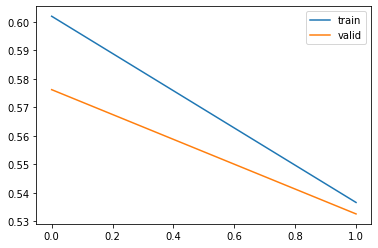

In [22]:
plot(train_losses, valid_losses, len(train_losses))


In [23]:


epochs = []
training_loss = []
validation_loss = []
rmse = []

for e in training_stats:
  epochs.append(e['epoch'])
  training_loss.append(e['Training Loss'])
  validation_loss.append(e['Valid. Loss'])
  rmse.append(e['Valid. RMSE.'])

plt.plot(epochs, training_loss, color = 'blue', label = 'training loss')
plt.plot(epochs, validation_loss, color = 'green', label = 'validation loss')
plt.title("Training and validation loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, rmse)
plt.title("RMSE per epoch")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.show()



NameError: ignored


#### Approach 2: No pre-trained representations

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)

In [ ]:

class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2) #Needed for LSTMs

        #lstm_out : (seq_len,batch_size,num_directions (2) * hidden_size (50))
        #hidden : (num_layers * num_directions, batch_size,hidden_size)
        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        #out : (1)
        out = self.hidden2label(lstm_out[-1]
        return out

#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)